# SSH Log Analysis

This notebook analyzes SSH login attempts from the log data, creating various visualizations to understand patterns and potential security concerns.

In [15]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Read the log file
with open(r'data\tutorialdata\mailsv\secure.log', 'r') as file:
    log_lines = file.readlines()

## Data Loading and Preparation

In [5]:
log_pattern = re.compile(
    r'(?P<weekday>\w+)\s+(?P<month>\w+)\s+(?P<day>\d+)\s+(?P<year>\d+)\s+(?P<time>\d+:\d+:\d+)\s+\S+\s+sshd\[\d+\]:\s+'
    r'(?P<action>Failed|Accepted)\s+password for\s+(invalid user\s+)?(?P<user>\w+)\s+from\s+(?P<ip>[\d\.]+)\s+port\s+(?P<port>\d+)\s+ssh2'
)

parsed_logs = []

for line in log_lines:
    match = log_pattern.search(line)
    if match:
        data = match.groupdict()
        timestamp_str = f"{data['year']} {data['month']} {data['day']} {data['time']}"
        data['timestamp'] = datetime.strptime(timestamp_str, "%Y %b %d %H:%M:%S")
        parsed_logs.append({
            'timestamp': data['timestamp'],
            'action': data['action'],
            'user': data['user'],
            'ip': data['ip'],
            'port': int(data['port'])
        })

# Create DataFrame
df = pd.DataFrame(parsed_logs)

In [13]:
df.head()

,timestamp,action,user,ip,port,hour
0,2025-04-30 13:22:50,Failed,guest,86.212.199.60,3771,13
1,2025-04-30 13:22:50,Failed,postgres,86.212.199.60,4093,13
2,2025-04-30 13:22:50,Failed,whois,86.212.199.60,3311,13
3,2025-04-30 13:22:50,Failed,info,86.212.199.60,4078,13
4,2025-04-30 13:22:50,Failed,postgres,86.212.199.60,1265,13


## 1. Login Attempts Over Time

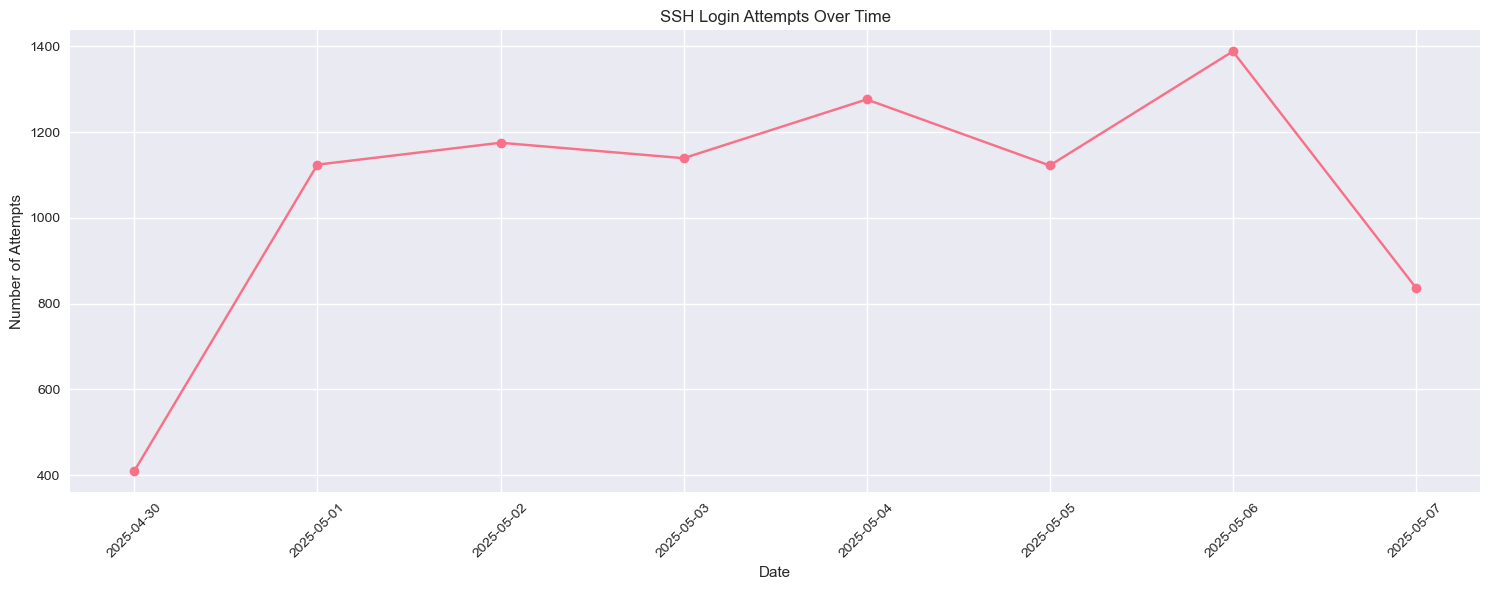

In [16]:
plt.figure(figsize=(15, 6))
df.groupby(df['timestamp'].dt.date).size().plot(kind='line', marker='o')
plt.title('SSH Login Attempts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Attempts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Success vs Failed Login Attempts

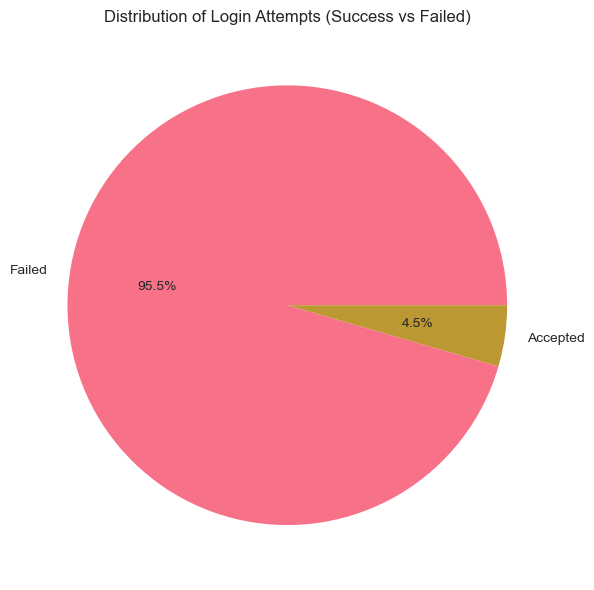

In [17]:
plt.figure(figsize=(10, 6))
df['action'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Login Attempts (Success vs Failed)')
plt.ylabel('')
plt.tight_layout()
plt.show()

## 3. Top IP Addresses Attempting to Log In

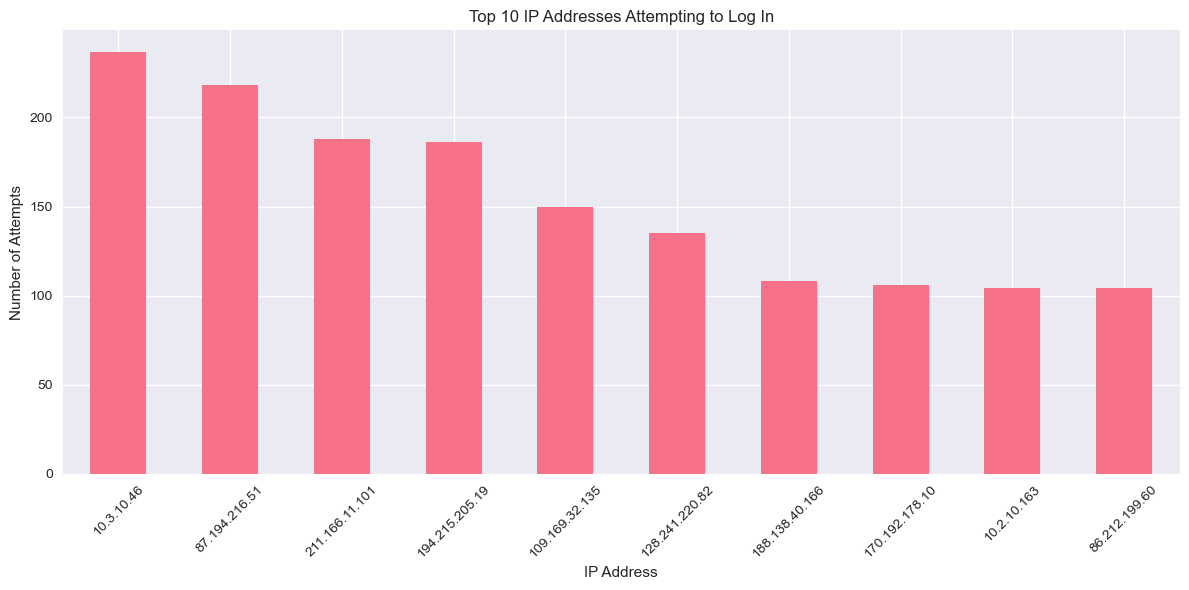

In [18]:
plt.figure(figsize=(12, 6))
df['ip'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 IP Addresses Attempting to Log In')
plt.xlabel('IP Address')
plt.ylabel('Number of Attempts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Most Targeted Users

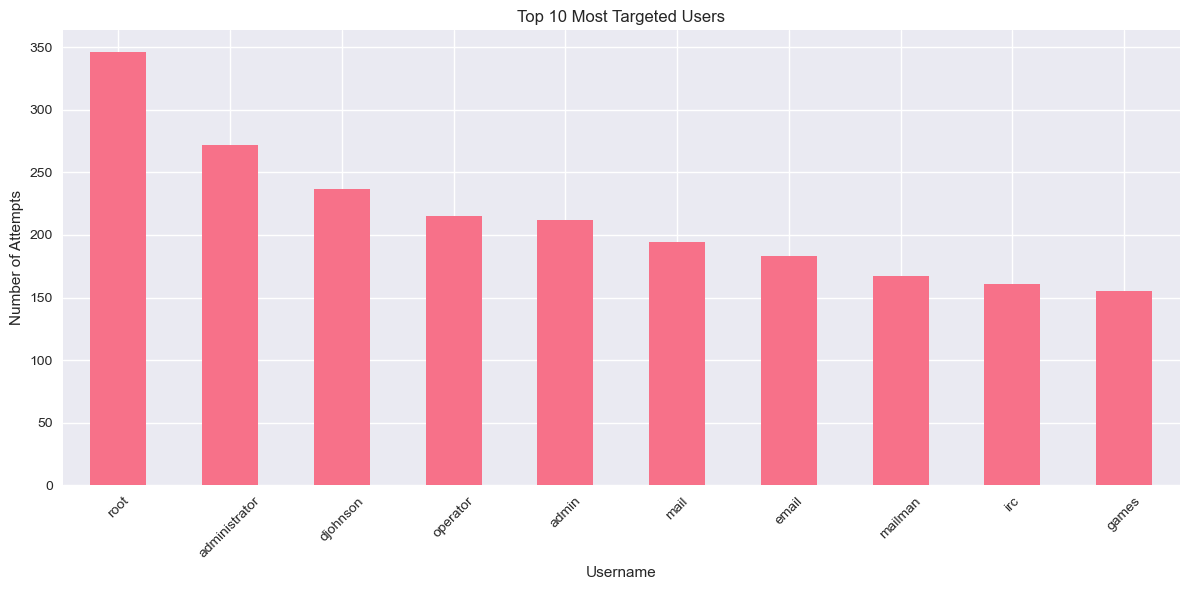

In [19]:
plt.figure(figsize=(12, 6))
df['user'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Most Targeted Users')
plt.xlabel('Username')
plt.ylabel('Number of Attempts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Login Attempts by Hour of Day

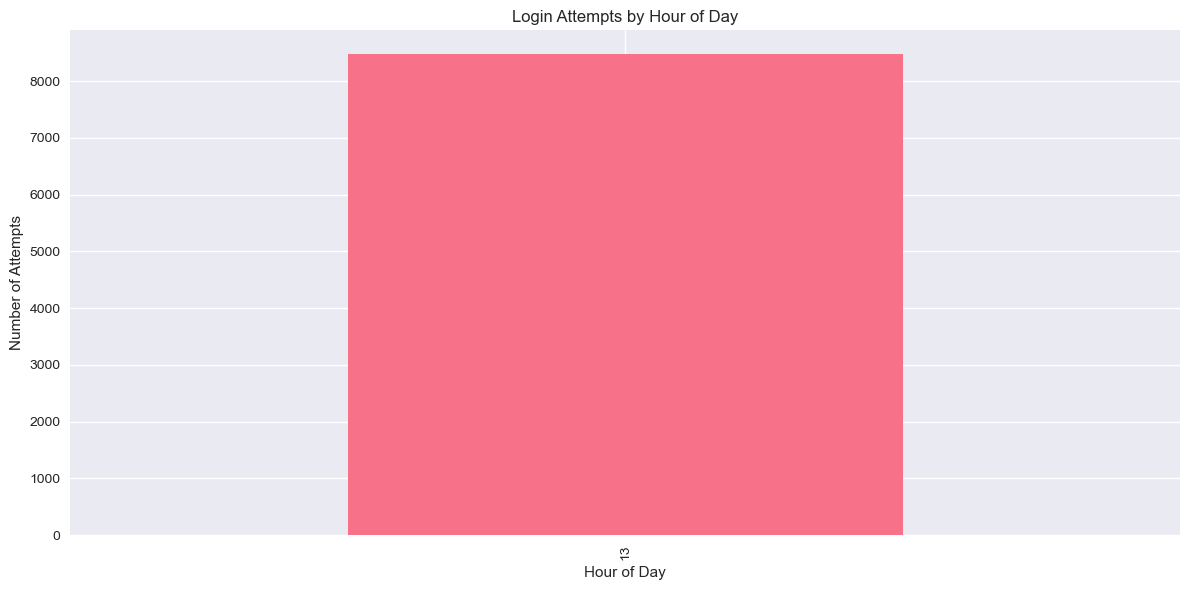

In [20]:
plt.figure(figsize=(12, 6))
df['hour'] = df['timestamp'].dt.hour
df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Login Attempts by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Attempts')
plt.tight_layout()
plt.show()

## 6. Success Rate by User

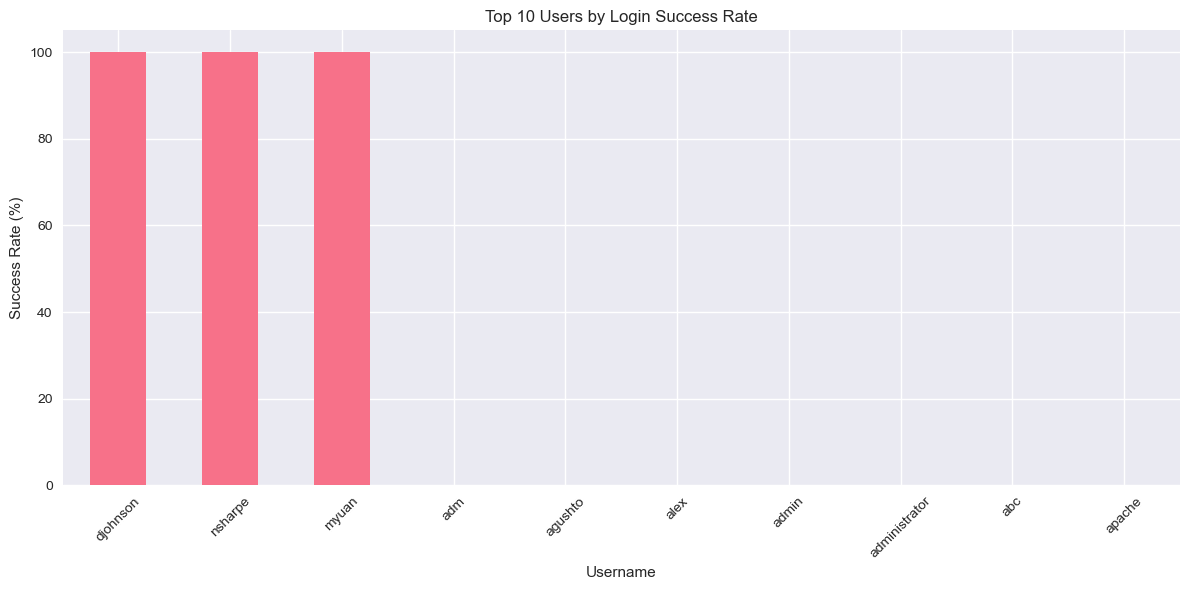

In [21]:
success_rate = df.groupby('user')['action'].apply(
    lambda x: (x == 'Accepted').mean() * 100
).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
success_rate.head(10).plot(kind='bar')
plt.title('Top 10 Users by Login Success Rate')
plt.xlabel('Username')
plt.ylabel('Success Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Summary Statistics

In [22]:
print("Summary Statistics:")
print(f"Total number of login attempts: {len(df)}")
print(f"Number of successful logins: {len(df[df['action'] == 'Accepted'])}")
print(f"Number of failed logins: {len(df[df['action'] == 'Failed'])}")
print(f"Success rate: {(len(df[df['action'] == 'Accepted']) / len(df) * 100):.2f}%")
print(f"Number of unique IP addresses: {df['ip'].nunique()}")
print(f"Number of unique users targeted: {df['user'].nunique()}")

Summary Statistics:
Total number of login attempts: 8471
Number of successful logins: 380
Number of failed logins: 8091
Success rate: 4.49%
Number of unique IP addresses: 181
Number of unique users targeted: 153
